# Virus Spread

This is a demonstration on how to use the [agentpy](https://agentpy.readthedocs.io) package to build and analyze an agent-based model that simulates the propagation of a disease. It shows how to create and visualize networks, plot interactive output, and perform a sobol sensitivity analysis. 

In the model, agents can be in one of three conditions: susceptible to the disease (S), infected (I), or recovered (R). They are connected to other agents through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

To start, we import agentpy as follows (recommended):

In [1]:
import agentpy as ap

import matplotlib.pyplot as plt
import seaborn as sns

## Defining the model

We define a new agent type `human` by creating a subclass of `ap.agent`. The method `setup()` is called automatically when an agent is created, and initializes our variable `condition`. The custom method `being_sick()` causes the agent to spread the disease to its peers and/or recover based on random chance. There are three tools that are used within this class:

- `agent.p` is used to access model parameters
- `agent.neighbors()` returns a list of the agents' peers in the network
- `random()` returns a uniform random draw between 0 and 1

In [2]:
from random import random

class human(ap.agent):
    
    def setup(self):  
        
        self.condition = 0 # Susceptible = 0, Infected = 1, Recovered = 2
        
    def being_sick(self):
        
        # Infect susceptible peers if succesfull
        for peer in self.neighbors('peer_network'): 
            if peer.condition == 0 and self.p.infection_chance > random():
                peer.condition = 1
        
        # Recover if succesfull
        if self.p.recovery_chance > random(): 
            self.condition = 2 

Next, we define our model `virus_model` by creating subclass of `model` with five methods:

- `model.setup()`  initializes the agents and network of the model 
- `model.step()` and defines the models' events per simulation step
- `model.update()` records variables after setup and each step
- `model.stop_if()` stops the simulation if it returns `True`
- `model.end()` records evaluation measures at the end

In [3]:
import networkx as nx

class virus_model(ap.model):
    
    def setup(self):
        
        # Transform integer parameters to `int`
        n = self.p.population = int(self.p.population)
        nn = self.p.number_of_neighbors = int(self.p.number_of_neighbors)
        
        # Create a small-world network with a networkx generator function
        small_world = nx.watts_strogatz_graph(n, nn, self.p.network_randomness)
        self.add_network('peer_network', graph = small_world ) 
        
        # Add human agents to network and map them to existing nodes
        self.peer_network.add_agents(n, human, map_to_nodes = True)
        
        # Infect a random share of the population
        I0 = int(self.p.initial_infections * n)
        self.agents.random(I0).condition = 1 

    def update(self):  
        
        # Susceptible, Infected, Recovered
        conditions = ('S','I','R')
        
        # Count agents with each condition
        for i,c in enumerate(conditions):
            self[c] = len( self.agents.condition == i ) / self.p.population
        
        # Record variables for later analysis
        self.record(conditions) 
        
    def step(self):   
        
        # Call 'being_sick' for infected agents
        (self.agents.condition == 1).being_sick()
        
    def stop_if(self):  
        
        # Stop simulation if disease is gone
        return self.I == 0
    
    def end(self):     
        
        # Record final evaluation measures
        self.measure( 'Total Infection Rate', self.I + self.R  ) 
        self.measure( 'Peak Infection Rate', max(self.log['I']) )

The formulation in `step()` uses the operator functions of `attr_list` that are inhereted by `agent_list`. The first element returns a list of agents where the condition is true, while the second one forwards the method call to all agents in the list.

    (self.agents.condition == 1).being_sick()

One could achieve the same effect with the two following alternatives:

    self.agents.select('condition',1).do('being_sick')

    for agent in self.agents:
        if agent.condition == 1:
            agent.being_sick()

## Running a simulation

To run our model, we define a dictionary with our `parameters`. We then create a new instance of our model, passing the parameters as an argument, and use the method `model.run()` to perform the simulation and return it's `output`. 

In [4]:
parameters = {
    
    'population':1000,
    'infection_chance':0.3,
    'recovery_chance':0.1,
    'initial_infections':0.1,
    'number_of_neighbors':2,
    'network_randomness':0.5
    
}

model = virus_model(parameters)
results = model.run() # returns model.output

Completed: 64 steps
Run time: 0:00:00.157910
Simulation finished


## Analyzing results

The results are given as a dictionary of recorded data and pandas dataframes:

- `log` holds information about the model and simulation performance.
- `model_vars` holds a dataframe with dynamic model variables that are recorded at different time-steps.
- `measures` holds a dataframe with evaluation measures that are recoreded only once per simulation.

In [5]:
results

data_dict {
'log': Dictionary with 4 keys
'parameters': Dictionary with 6 keys
'measures': DataFrame with 2 variables and 1 row
'variables': DataFrame with 3 variables and 65 rows }

To visualize the evolution of our `model_vars`, we create a matplotlib plot function `virus_stackplot()`.

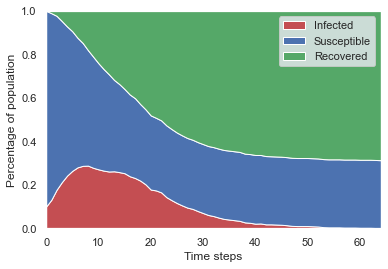

In [6]:
def virus_stackplot(data,ax):
    
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I','S','R']]
    
    ax.stackplot(x, y, labels=['Infected','Susceptible','Recovered'], colors = ['r','b','g'])    
    
    ax.legend()
    ax.grid(False)
    ax.set_xlim(0,max(1,len(x)-1))
    ax.set_ylim(0,1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")

sns.set() # Set seaborn style
fig, ax = plt.subplots() # Initialize plot
virus_stackplot(results.variables, ax)

## Animating a simulation

We can also observe the development of our model over time. We define a function `animation_plot()` that takes a model instance and displays the previous stackplot together with a network graph for a passed model instance. The function `animate()` will call this plot function for every time-step and return a matplotlib animation object.

In [7]:
def animation_plot(m,axs):
    
    ax1,ax2 = axs
    
    # Plot stackplot on first axis
    virus_stackplot(m.output.variables, ax1)
    
    # Plot network on second axis
    color_dict = { 0 : 'b', 1 : 'r', 2 : 'g' }
    colors = [ color_dict[c] for c in m.agents.condition ]
    nx.draw_circular(m.peer_network.graph, node_color=colors, node_size=50, ax=ax2)

sns.set() # Set seaborn style
fig, axs = plt.subplots(1,2,figsize=(8,4)) # Prepare figure 
parameters['population'] = 50 # Reduce population for better visibility 
animation = ap.animate(virus_model, parameters, fig, axs, animation_plot)

In Jupyter, we can use `.to_jshtml()` and `HTML` to display the animation object directly.

In [8]:
from IPython.display import HTML
HTML(animation.to_jshtml()) 

## Interactive parameter variation

To experiment with different parameter values, we define a dictionary `param_ranges`, where we declare tuples with a minimum and maximum value for parameters that we want to vary, as well as a function `interactive_plot()` that takes the model output and displays both our measures and variables.

In [9]:
param_ranges = {
    
    'population':(100,1000),
    'infection_chance':(0,1),
    'recovery_chance':(0,1),
    'initial_infections':0.1,
    'number_of_neighbors':2,
    'network_randomness':(0,1)
    
}

def interactive_plot(output):
    
    # Display measures
    print(output.measures)
    
    # Display model_vars
    fig,ax = plt.subplots()
    virus_stackplot(output.variables,ax) 

In Jupyter, we can then use the function `interactive()` to display our plot with a widget to change parameter values.

In [10]:
ap.interactive(virus_model,param_ranges,interactive_plot)

## Experiment with multiple runs

To look into parameter variations in more detail, we use `sample_saltelli()` create a sample of different parameter combinations. We then use `exp()` to perform an experiment that runs our model repeatedly over the whole sample.

In [11]:
sample = ap.sample_saltelli(param_ranges, N=1000)
exp = ap.experiment(virus_model, sample)
results = exp.run()

Scheduled runs: 10000
Completed: 10000, estimated time remaining: 0:00:00
Run time: 0:21:12.066373
Simulation finished


We can save and load agentpy output data with `save()` and `load()`.

In [12]:
results.save() # Alternative: ap.save(results)

Data saved to ap_output/virus_model_1


In [13]:
results = ap.load('virus_model') # Load data

Loading from directory ap_output/virus_model_1/
Loading log.json - Successful
Loading measures.csv - Successful
Loading parameters_fixed.json - Successful
Loading parameters_varied.csv - Successful
Loading variables.csv - Successful


The measures in our data_dict now hold one row for each simulation run.

In [14]:
results

data_dict {
'log': Dictionary with 5 keys
'measures': DataFrame with 2 variables and 10000 rows
'parameters': data_dict {
    'fixed': Dictionary with 2 keys
    'varied': DataFrame with 4 variables and 10000 rows }
'variables': DataFrame with 3 variables and 645901 rows }

We can use standard functions of the pandas library like `pandas.DataFrame.hist()` to look at summary statistics.

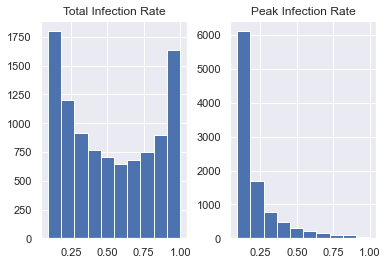

In [15]:
results.measures.hist()
plt.show()

## Sensitivity analysis

The function `sensitivity()` calculates sobol sensitivity indices for the passed results and parameter ranges, using the [SAlib]( https://salib.readthedocs.io/en/latest/basics.html) package. This adds two new categories to our results:

- `sensitivity` - first-order sobol sensitivity indices
- `sensitivity_conf` - confidence ranges for the above indices

In [16]:
ap.sensitivity( results, param_ranges )

S1        ST
measure              parameter                             
Total Infection Rate population         -0.004869  0.019708
                     infection_chance    0.714047  0.805062
                     recovery_chance     0.194795  0.271377
                     network_randomness -0.005812  0.020597
Peak Infection Rate  population         -0.007028  0.016434
                     infection_chance    0.195267  0.329308
                     recovery_chance     0.649690  0.789410
                     network_randomness  0.003861  0.021419

We can use the pandas functionalities to create a bar plot `plot_sobol_indices()` that visualizes our sensitivities.

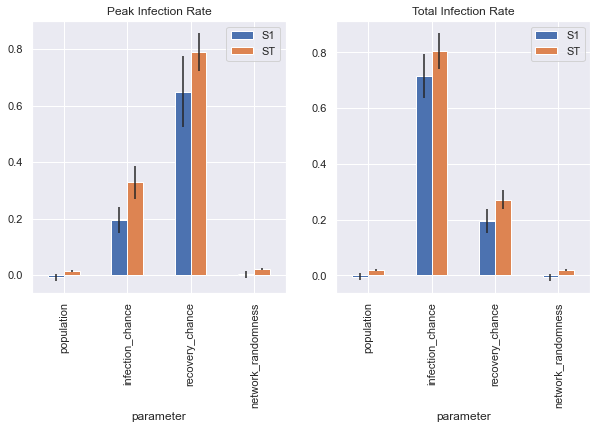

In [17]:
def plot_sobol_indices(results):
    
    sns.set()
    fig, axs = plt.subplots(1,2,figsize=(10,5))

    SI = results.sensitivity.groupby(by='measure')
    SIT = results.sensitivity_conf.groupby(by='measure')

    for (key,si),(_,err),ax in zip(SI, SIT, axs):

        si = si.droplevel('measure')
        err = err.droplevel('measure')
        si.plot.bar(yerr=err,title=key,ax=ax)
        
plot_sobol_indices(results)

Alternatively, we can also display the sensitivities by plotting average evaluation measures over our parameter variations. 

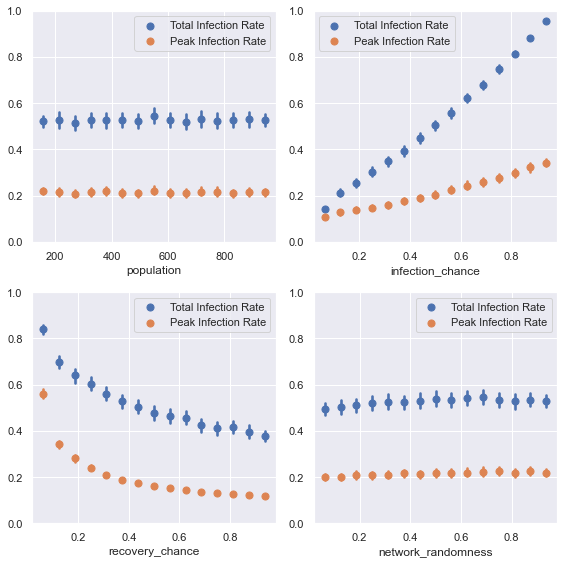

In [18]:
def virus_scatterplot(results):
    
    fig, axs = plt.subplots(2,2,figsize=(8,8))
    
    data = results.arrange(('measures','parameters'))
    params = results.parameters.varied.keys() # List of varied parameter keys
    axs = [i for j in axs for i in j] # Flatten axis list
    
    for x,ax in zip(params,axs):
        for y in results.measures.columns:
            sns.regplot(x=x, y=y, data=data, ax = ax, ci=99, x_bins=15, fit_reg=False, label=y)
        
        ax.set_ylim(0,1)
        ax.set_ylabel('')
        ax.legend()
        
    plt.tight_layout()

virus_scatterplot(results)